# EE4375: Second Lab Session: FDM 1D Poisson: Functions, StaticArrays, Type Stability and Benchmarking

## Import Packages  

In [1]:
using LinearAlgebra 
using SparseArrays 
using StaticArrays

using IterativeSolvers
using Preconditioners

using BenchmarkTools
using Profile
using ProfileView

using Plots 

## Section 1:/ Introduction 
Motivation 
1. build matrix as sparse directly, i.e., avoid convection from dense to sparse matrix;
2. use staticArrays in storing the matrix stencil and in building the sparse matrix; 
3. use code as building block for more complex code; 
4. profile code in terms of type-stability, memory and CPU usage; 
5. test single dispatch on direct solver algorithm: should 1D Poisson matrix be solved as tri-diagonal matrix or as a general sparse matrix? 
6. unit test the code (compare with analytical solution or rate of converge); 
7. upload the code of github to work with github actions;

## Section 2/: Build Linear System as Sparse From the Start 

### Section 1.2: Build Coefficient Matrix 
We specify the type of the input argument N to providing the compiler more informartion to perform required optimizations. In the following, we 
1. test the code on small input values. Observe that the output is a sparse matrix. This output can be converted to a full matrix using the Matrix()-function; 
2. verify the type stability of the code;
3. benchmark the code for number of allocation and runtime using both @time and @btime macros;

Note that the type-instability that @code_warntype is considered harmless as reported [here](https://discourse.julialang.org/t/how-to-prevent-type-instability-in-for-loops/30508). 

In [2]:
function buildMatAppend1D(N::Int64)
  Nm1::Int64 = N-1; Np1::Int64 = N+1 
  h::Float64 = 1/N; h2::Float64 = h*h; 
  stencil = Vector{Float64}([-1/h2, 2/h2, -1/h2]);
  #..Allocate row, column and value vector 
  I = Int64[]; sizehint!(I, 3*Nm1); 
  J = Int64[]; sizehint!(J, 3*Nm1); 
  vals=Float64[]; sizehint!(vals, 3*Nm1);
  for i in 2:N  
    append!(I, SA[i,i,i])
    append!(J, SA[i-1,i,i+1])
    append!(vals,stencil) 
  end 
  #..Build matrix for interior rows   
  A = sparse(I,J,vals,Np1,Np1)
  #..Build matrix for boundary rows
  A[1,1] = 1; A[end,end]=1; A[2,1] =0; A[end-1,end]=0; 
  return A 
end 

buildMatAppend1D (generic function with 1 method)

In [3]:
@time buildMatAppend1D(128);

  0.021762 seconds (2.62 k allocations: 153.141 KiB, 99.75% compilation time)


In [4]:
function buildMat1D(N::Int64)
  Nm1::Int64 = N-1; Np1::Int64 = N+1 
  h::Float64 = 1/N; h2::Float64 = h*h; 

  #..Allocate local irang, Iloc, Jloc and Aloc vector     
  irng = UnitRange{Int64}(1,3)
  Iloc = Array{Int64}(undef, 3)
  Jloc = Array{Int64}(undef, 3)
  Aloc = Vector{Float64}([-1/h2, 2/h2, -1/h2]);

  #..Allocate global I, J and vals vector 
  I = zeros(Int64,3*Nm1); 
  J = zeros(Int64,3*Nm1); 
  vals = zeros(Float64,3*Nm1);
    
  for i in 2:N #..loop over internal rows  
    irng = UnitRange(3*(i-2)+1,3*(i-1));
    I[irng]    .= SA[i,i,i]; #..use .= operator to overwrite elements of a container
    J[irng]    .= SA[i-1,i,i+1]; 
    vals[irng] .= Aloc;         
  end 
    
  #..Build matrix for interior rows   
  A = sparse(I,J,vals,Np1,Np1)
  #..Build matrix for boundary rows
  A[1,1] = 1; A[end,end]=1; A[2,1] =0; A[end-1,end]=0; 
  return A 
end

buildMat1D (generic function with 1 method)

In [5]:
@time buildMat1D(64)

  0.000018 seconds (17 allocations: 24.766 KiB)


65×65 SparseMatrixCSC{Float64, Int64} with 191 stored entries:
⠳⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠁

In [6]:
?SparseArrays.sparse!

```
sparse!(I::AbstractVector{Ti}, J::AbstractVector{Ti}, V::AbstractVector{Tv},
        m::Integer, n::Integer, combine, klasttouch::Vector{Ti},
        csrrowptr::Vector{Ti}, csrcolval::Vector{Ti}, csrnzval::Vector{Tv},
        [csccolptr::Vector{Ti}], [cscrowval::Vector{Ti}, cscnzval::Vector{Tv}] ) where {Tv,Ti<:Integer}
```

Parent of and expert driver for [`sparse`](@ref); see [`sparse`](@ref) for basic usage. This method allows the user to provide preallocated storage for `sparse`'s intermediate objects and result as described below. This capability enables more efficient successive construction of [`SparseMatrixCSC`](@ref)s from coordinate representations, and also enables extraction of an unsorted-column representation of the result's transpose at no additional cost.

This method consists of three major steps: (1) Counting-sort the provided coordinate representation into an unsorted-row CSR form including repeated entries. (2) Sweep through the CSR form, simultaneously calculating the desired CSC form's column-pointer array, detecting repeated entries, and repacking the CSR form with repeated entries combined; this stage yields an unsorted-row CSR form with no repeated entries. (3) Counting-sort the preceding CSR form into a fully-sorted CSC form with no repeated entries.

Input arrays `csrrowptr`, `csrcolval`, and `csrnzval` constitute storage for the intermediate CSR forms and require `length(csrrowptr) >= m + 1`, `length(csrcolval) >= length(I)`, and `length(csrnzval >= length(I))`. Input array `klasttouch`, workspace for the second stage, requires `length(klasttouch) >= n`. Optional input arrays `csccolptr`, `cscrowval`, and `cscnzval` constitute storage for the returned CSC form `S`. `csccolptr` requires `length(csccolptr) >= n + 1`. If necessary, `cscrowval` and `cscnzval` are automatically resized to satisfy `length(cscrowval) >= nnz(S)` and `length(cscnzval) >= nnz(S)`; hence, if `nnz(S)` is unknown at the outset, passing in empty vectors of the appropriate type (`Vector{Ti}()` and `Vector{Tv}()` respectively) suffices, or calling the `sparse!` method neglecting `cscrowval` and `cscnzval`.

On return, `csrrowptr`, `csrcolval`, and `csrnzval` contain an unsorted-column representation of the result's transpose.

You may reuse the input arrays' storage (`I`, `J`, `V`) for the output arrays (`csccolptr`, `cscrowval`, `cscnzval`). For example, you may call `sparse!(I, J, V, csrrowptr, csrcolval, csrnzval, I, J, V)`.

For the sake of efficiency, this method performs no argument checking beyond `1 <= I[k] <= m` and `1 <= J[k] <= n`. Use with care. Testing with `--check-bounds=yes` is wise.

This method runs in `O(m, n, length(I))` time. The HALFPERM algorithm described in F. Gustavson, "Two fast algorithms for sparse matrices: multiplication and permuted transposition," ACM TOMS 4(3), 250-269 (1978) inspired this method's use of a pair of counting sorts.


In [7]:
B = Matrix(A)

LoadError: UndefVarError: A not defined

In [8]:
typeof(B)

LoadError: UndefVarError: B not defined

In [9]:
@code_warntype buildMat1D(5)

MethodInstance for buildMat1D(::Int64)
  from buildMat1D(N::Int64) in Main at In[4]:1
Arguments
  #self#::Core.Const(buildMat1D)
  N::Int64
Locals
  @_3::Union{Nothing, Tuple{Int64, Int64}}
  A::SparseMatrixCSC{Float64, Int64}
  vals::Vector{Float64}
  J::Vector{Int64}
  I::Vector{Int64}
  Aloc::Vector{Float64}
  Jloc::Vector{Int64}
  Iloc::Vector{Int64}
  irng::UnitRange{Int64}
  h2::Float64
  h::Float64
  Np1::Int64
  Nm1::Int64
  i::Int64
Body::SparseMatrixCSC{Float64, Int64}
1 ─       Core.NewvarNode(:(A))
│   %2  = (N - 1)::Int64
│   %3  = Base.convert(Main.Int64, %2)::Int64
│         (Nm1 = Core.typeassert(%3, Main.Int64))
│   %5  = (N + 1)::Int64
│   %6  = Base.convert(Main.Int64, %5)::Int64
│         (Np1 = Core.typeassert(%6, Main.Int64))
│   %8  = (1 / N)::Float64
│   %9  = Base.convert(Main.Float64, %8)::Float64
│         (h = Core.typeassert(%9, Main.Float64))
│   %11 = (h * h)::Float64
│   %12 = Base.convert(Main.Float64, %11)::Float64
│         (h2 = Core.typeassert(%12, 

In [10]:
@benchmark buildMat1D(1000)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  34.125 μs …   3.612 ms  ┊ GC (min … max):  0.00% … 98.81%
 Time  (median):     44.750 μs               ┊ GC (median):     0.00%
 Time  (mean ± σ):   52.949 μs ± 163.682 μs  ┊ GC (mean ± σ):  15.45% ±  4.92%

                    ▄███▃                                       
  ▁▂▃▃▂▂▂▁▁▁▁▁▁▁▁▂▄▇█████▇▆▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  34.1 μs         Histogram: frequency by time           65 μs <

 Memory estimate: 305.66 KiB, allocs estimate: 24.

### Section 2.2: Construction of the Right-Hand Side Vector

In [11]:
function buildRhs1D(N::Int64,sourceFct::Function)
  h::Float64 = 1/N;
  x = Vector(0:h:1)
  #..Build vector for interior rows 
  f = sourceFct.(x)
  #..Build matrix for boundary rows
  f[1] = 0; f[end] = 0; 
  return f 
end 

buildRhs1D (generic function with 1 method)

In [12]:
sourceFct(x)= x*sin(π*x)

sourceFct (generic function with 1 method)

In [13]:
f = buildRhs1D(5,sourceFct);
display(f)

6-element Vector{Float64}:
 0.0
 0.11755705045849463
 0.3804226065180614
 0.5706339097770922
 0.4702282018339786
 0.0

In [14]:
@code_warntype buildRhs1D(5,sourceFct)

MethodInstance for buildRhs1D(::Int64, ::typeof(sourceFct))
  from buildRhs1D(N::Int64, sourceFct::Function) in Main at In[11]:1
Arguments
  #self#::Core.Const(buildRhs1D)
  N::Int64
  sourceFct::Core.Const(sourceFct)
Locals
  f::Vector{Float64}
  x::Vector{Float64}
  h::Float64
Body::Vector{Float64}
1 ─ %1  = (1 / N)::Float64
│   %2  = Base.convert(Main.Float64, %1)::Float64
│         (h = Core.typeassert(%2, Main.Float64))
│   %4  = (0:h:1)::StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}
│         (x = Main.Vector(%4))
│   %6  = Base.broadcasted(sourceFct, x)::Base.Broadcast.Broadcasted{Base.Broadcast.DefaultArrayStyle{1}, Nothing, typeof(sourceFct), Tuple{Vector{Float64}}}
│         (f = Base.materialize(%6))
│         Base.setindex!(f, 0, 1)
│   %9  = f::Vector{Float64}
│   %10 = Base.lastindex(f)::Int64
│         Base.setindex!(%9, 0, %10)
└──       return f



In [15]:
@benchmark buildRhs1D(1000,sourceFct)

BenchmarkTools.Trial: 10000 samples with 5 evaluations.
 Range (min … max):  5.967 μs …  2.349 ms  ┊ GC (min … max):  0.00% … 99.57%
 Time  (median):     6.950 μs              ┊ GC (median):     0.00%
 Time  (mean ± σ):   8.042 μs ± 39.419 μs  ┊ GC (mean ± σ):  12.86% ±  2.81%

                ▂▄▆█▇▅▁                                       
  ▂▂▂▂▂▂▂▁▂▂▂▂▄▅███████▅▅▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  5.97 μs        Histogram: frequency by time        9.17 μs <

 Memory estimate: 16.05 KiB, allocs estimate: 5.

### Section 3.2: Solve the Linear System - Default Versions 
Here we employ a sparse direct solver. 

In [16]:
function solvePoisson1D(N::Int64,sourceFct::Function)
  A = buildMat1D(N);
  f = buildRhs1D(N,sourceFct)
  u = A\f 
  return u 
end

solvePoisson1D (generic function with 1 method)

In [17]:
@code_warntype solvePoisson1D(5,sourceFct)

MethodInstance for solvePoisson1D(::Int64, ::typeof(sourceFct))
  from solvePoisson1D(N::Int64, sourceFct::Function) in Main at In[16]:1
Arguments
  #self#::Core.Const(solvePoisson1D)
  N::Int64
  sourceFct::Core.Const(sourceFct)
Locals
  u::Vector{Float64}
  f::Vector{Float64}
  A::SparseMatrixCSC{Float64, Int64}
Body::Vector{Float64}
1 ─     (A = Main.buildMat1D(N))
│       (f = Main.buildRhs1D(N, sourceFct))
│       (u = A \ f)
└──     return u



In [18]:
@benchmark solvePoisson1D(1000,sourceFct)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  194.125 μs …   8.450 ms  ┊ GC (min … max): 0.00% … 76.67%
 Time  (median):     216.083 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   243.493 μs ± 315.337 μs  ┊ GC (mean ± σ):  5.99% ±  4.39%

                 ▁█▇▅▁                                           
  ▁▃▄▃▂▁▁▁▂▂▂▂▂▃▅█████▇▆▅▅▆▅▅▅▆▅▅▅▄▃▃▃▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▃
  194 μs           Histogram: frequency by time          261 μs <

 Memory estimate: 730.67 KiB, allocs estimate: 88.

In [19]:
# algorithm being used to solve the linear system 
# use edit("/Applications/Julia-1.8.app/Contents/Resources/julia/share/julia/stdlib/v1.8/SparseArrays/src/linalg.jl:1548")
# to view the source code 
methods(\, (SparseMatrixCSC{Float64, Int64}, Vector{Float64}))

# 1 method for generic function "\":
[1] \(A::SparseArrays.AbstractSparseMatrixCSC, B::AbstractVecOrMat) in SparseArrays at /Applications/Julia-1.8.app/Contents/Resources/julia/share/julia/stdlib/v1.8/SparseArrays/src/linalg.jl:1548

### Section 4.2: Solve the Linear System - Alternative Versions 
Here we employ a general sparse, tridiagonal and general sparse solver. Conversion from general sparse to tridiagonal requires CPU time as well. 

In [20]:
function solvePoisson1D(N::Int64,sourceFct::Function)
  A = buildMat1D(N);
  # B = Matrix(A)
  # B = Tridiagonal(A) 
  # B = sparse(B)
  #  B = A; 
  f = buildRhs1D(N,sourceFct)
  u = A\f 
  return u 
end

solvePoisson1D (generic function with 1 method)

In [21]:
@benchmark solvePoisson1D(1000,sourceFct)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  193.708 μs …   5.564 ms  ┊ GC (min … max): 0.00% … 40.19%
 Time  (median):     214.959 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   239.251 μs ± 298.426 μs  ┊ GC (mean ± σ):  5.49% ±  4.17%

                    ▃█▇▂                                         
  ▂▃▄▃▂▁▁▁▁▁▁▁▁▂▂▃▄▆████▆▅▃▃▂▂▂▂▂▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  194 μs           Histogram: frequency by time          258 μs <

 Memory estimate: 730.67 KiB, allocs estimate: 88.

In [22]:
# algorithm being used to solve the linear system 
methods(\, (Matrix{Float64}, Vector{Float64}))

# 1 method for generic function "\":
[1] \(A::AbstractMatrix, B::AbstractVecOrMat) in LinearAlgebra at /Applications/Julia-1.8.app/Contents/Resources/julia/share/julia/stdlib/v1.8/LinearAlgebra/src/generic.jl:1096

## Section 3/: Spectral Analysis of the coefficient matrix 

Here we compute eigenvalues and eigenvectors of the matrix A. 

In [23]:
A = buildMat1D(32);

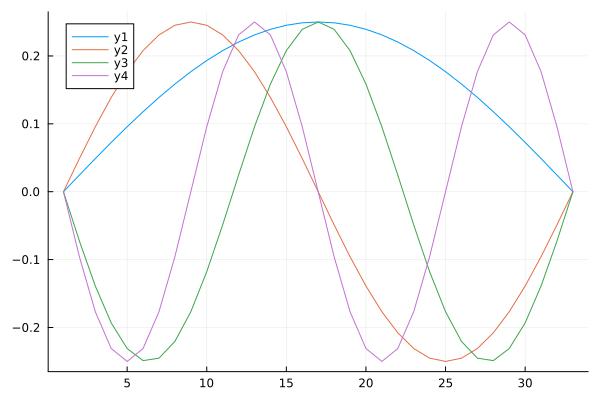

In [30]:
F = eigen(Matrix(A)) # compute eigenvectors and eigenvalues of A converted to full matrix
plot(F.vectors[:,3:6]) # plot eigenmodes 3 to 6 